In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2 

In [2]:
import os
import datajoint as dj
dj.config['database.host'] = os.environ['DJ_HOST']
dj.config['database.user'] = os.environ['DJ_USER']
dj.config['database.password'] = os.environ['DJ_PASS']
dj.config['enable_python_native_blobs'] = True
dj.config['display.limit'] = 200

name = 'interspecies_development'
os.environ["DJ_SCHEMA_NAME"] = f"konstantin_nnsysident_{name}"

In [3]:
import re
import torch
import numpy as np
import pickle 
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 25)
from collections import OrderedDict, Iterable
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import hiplot as hip

import nnfabrik
from nnfabrik.main import *
from nnfabrik import builder
from nnfabrik.utility.hypersearch import Bayesian

from nnsysident.tables.experiments import *
from nnsysident.tables.bayesian import *
from nnsysident.datasets.mouse_loaders import static_shared_loaders, static_loaders, static_loader
from nnsysident.tables.scoring import OracleScore, OracleScoreTransfer

from dataport.bcm.static import PreprocessedMouseData

<ipython-input-3-8cd5ec436f4e>:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import OrderedDict, Iterable


Connecting konstantin@134.2.168.16:3306


---

# Hyperparameters

### Difference in perfromance (indiv hyperparams vs. same hyperparams)

In [ ]:
experiment_names = ['Transfer between areas (indiv. hyperparams)']
 
# Fetch data
data = pd.DataFrame()
for experiment_name in experiment_names:
    data_ = pd.DataFrame(((TrainedModelTransfer * 
                           ExperimentsTransfer.Restrictions & 
                           'experiment_name="{}"'.format(experiment_name)) *
                          Dataset * Model * Trainer * Transfer * Seed ).fetch()) #* OracleScoreTransfer
    data = pd.concat([data, data_])

# # Filter out best performing models over model seeds
data = data.sort_values('score', ascending=False).drop_duplicates(['dataset_comment', 'transfer_comment'])
# data = data.loc[data['seed'] == 1]

# # Get labels
data["target data"] = data.apply(lambda row: row['dataset_comment'].split("Transfer dataset: ")[1].split(" neurons (218)")[0] , axis=1)
data["origin data (used for core)"] = data.apply(lambda row: row['transfer_comment'].split(" core")[0] , axis=1)

data = data.pivot(index="origin data (used for core)", columns='target data', values='score')
data = data.round(2)
# data = (data/data.max()*100).round(1)

diff_data = data

In [ ]:
experiment_names = ['Transfer between areas']
 
# Fetch data
data = pd.DataFrame()
for experiment_name in experiment_names:
    data_ = pd.DataFrame(((TrainedModelTransfer * 
                           ExperimentsTransfer.Restrictions & 
                           'experiment_name="{}"'.format(experiment_name)) *
                          Dataset * Model * Trainer * Transfer * Seed ).fetch()) #* OracleScoreTransfer
    data = pd.concat([data, data_])

# # Filter out best performing models over model seeds
data = data.sort_values('score', ascending=False).drop_duplicates(['dataset_comment', 'transfer_comment'])
# data = data.loc[data['seed'] == 1]

# # Get labels
data["target data"] = data.apply(lambda row: row['dataset_comment'].split("Transfer dataset: ")[1].split(" neurons (218)")[0] , axis=1)
data["origin data (used for core)"] = data.apply(lambda row: row['transfer_comment'].split(" core")[0] , axis=1)

data = data.pivot(index="origin data (used for core)", columns='target data', values='score')
data = data.round(2)
# data = (data/data.max()*100).round(1)

diff_data = diff_data - data

In [ ]:
paper_rc = {'lines.linewidth': 4, 'lines.markersize': 10}  
with sns.plotting_context('paper', rc=paper_rc, font_scale=2.15), sns.color_palette('bright'), sns.axes_style('ticks'):   

    fig, axes = plt.subplots(figsize=(13, 10), dpi=70)
    sns.heatmap(diff_data, annot=True, fmt="g", cmap='rocket_r', ax=axes, linewidths=.5, square=True, cbar_kws={'label': 'indiv - common hyperparams'})
#     fig.savefig('inter_area.png', bbox_inches='tight')

---

### Improvement by hypersearch compared to no indiv hyperparams

In [6]:
experiment_names = ['Direct cores on 1 area each', 'Direct cores on 1 area each (indiv. hyperparams)']
 
# Fetch data
data = pd.DataFrame()
for experiment_name in experiment_names:
    data_ = pd.DataFrame(((TrainedModel * 
                           Experiments.Restrictions & 
                           'experiment_name="{}"'.format(experiment_name)) *
                          Dataset * Model * Trainer * Seed ).fetch()) #* OracleScoreTransfer
#     data_ = data_.sort_values('score', ascending=False).drop_duplicates(['dataset_comment'])
    data = pd.concat([data, data_])
    
data = pd.concat([data, data['dataset_config'].apply(pd.Series)], axis = 1)
data['areas'] = data['areas'].astype(str)
data.replace({'Direct cores on 1 area each': 'common config', 'Direct cores on 1 area each (indiv. hyperparams)': 'indiv. config'}, inplace=True)

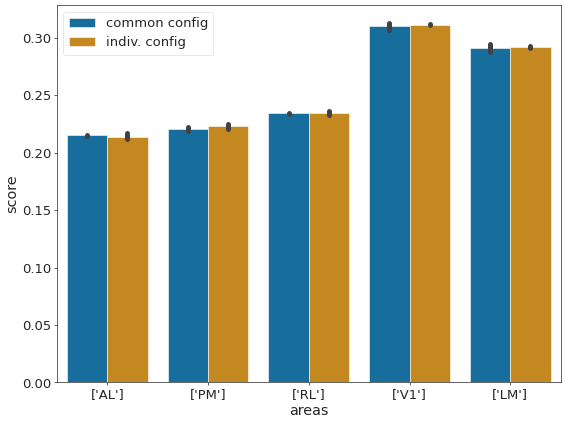

In [7]:
paper_rc = {'lines.linewidth': 4, 'lines.markersize': 10}  
with sns.plotting_context('paper', rc=paper_rc, font_scale=2.15), sns.color_palette('colorblind'), sns.axes_style('ticks'):   

    fig, axes = plt.subplots(figsize=(13, 10), dpi=50)
    sns.barplot(x="areas", y="score", hue="experiment_name", data=data, ax=axes)
    handles, labels = axes.get_legend_handles_labels()
    axes.legend(handles=handles[:], labels=labels[:])
    #     fig.savefig('inter_area.png', bbox_inches='tight')


---

### Best Hyperparameters per area

In [ ]:
all_info = pd.DataFrame((TrainedModelBayesian * ModelBayesian * DatasetBayesian).fetch())
all_info = pd.concat([all_info, all_info['dataset_config'].apply(pd.Series)], axis = 1).drop('dataset_config', axis = 1)
all_info.rename(columns={'layers': 'brain_layers'}, inplace=True)
all_info = pd.concat([all_info, all_info['model_config'].apply(pd.Series)], axis = 1).drop('model_config', axis = 1)
all_info['areas'] = all_info['areas'].astype(str)

one_exp = all_info #all_info.loc[all_info['areas'] == "['V1']"]
one_exp_h = one_exp.set_index('score', drop=False).copy()
cols = ['score', 'gamma_readout', 'layers', 'hidden_channels', 'areas']
hip.Experiment.from_dataframe(one_exp_h[cols]).display(force_full_width=False)

In [ ]:
data = pd.DataFrame(Model().fetch())
data = pd.concat([data, data['model_config'].apply(pd.Series)], axis = 1)
data = data.replace(' model', '', regex=True)

In [ ]:
paper_rc = {'lines.linewidth': 4, 'lines.markersize': 20}  
with sns.plotting_context('paper', rc=paper_rc, font_scale=2.15), sns.color_palette('colorblind'), sns.axes_style('ticks'):   

    fig, axes = plt.subplots(figsize=(10, 5), dpi=80)
    sns.barplot(x='model_comment', y='layers', data=data, ax=axes)
    axes.set_xlabel('')
#     axes.set_yticks([4, 5, 6, 7, 8])
    sns.despine(trim=True)